# Semantic Similarity Project
Author: Kesi
<br> Date: June 2025
<br> Kernel: workshop_311
<br> Goals: Compute the semantic similarity between word pairs and analyze how it affects recall ability across different stimulus conditions.

In [3]:
subj_list = ['M1005', 'M1006', 'M1007', 'M1008', 'M1011', 'M1012', 'M1013']
subject_dataframes = {}
all_cr_data = []

#Import the modules you will need for general analysis
import pprint
import numpy as np
import pandas as pd
import os
import pprint

#Import the modules you need for plotting graphs and stuff
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Load the necessary tools for word2vec
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors.bin', binary=True)

#### Finding the number of sessions & general experoiments' data

In [4]:
# Determine current working dierectory then define path where the patient data is located
# Use the print function to make sure it worked
# Get all folder names in the specified directory
# Filter the folder names to match the pattern 'Session_X'
# Sort the sessions in case they are not in order
# Print the result

!pwd

for subj in subj_list:
    print(f"\nProcessing Subject: {subj}")
    directory_path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}/'
    folder_names = os.listdir(directory_path)
    sessions = [int(folder.split('_')[1]) for folder in folder_names if folder.startswith('session_')]
    sessions.sort()
    print(sessions)

/home1/kesi/semanticSimilarity

Processing Subject: M1005
[0, 1, 2, 3, 4]

Processing Subject: M1006
[0, 1, 2]

Processing Subject: M1007
[0, 1]

Processing Subject: M1008
[0, 1]

Processing Subject: M1011
[0, 1, 2, 3, 4]

Processing Subject: M1012
[0, 1, 2, 3]

Processing Subject: M1013
[0, 1]


In [5]:
# FUNCTION TO FIND STIM SITES

import json
import re

def extract_stim_sites(sessions, directory_path):
    
    stim_sites_by_session = []

    for session in sessions:
        log_file = os.path.join(directory_path, f'session_{session}', 'elemem', 'event.log')

        # Read the log file
        try:
            with open(log_file, "r") as file:
                for line in file:
                    if '"type": "CONFIGURE"' in line:
                        try:
                            log_entry = json.loads(line.strip())
                            if "data" in log_entry and log_entry["data"]:
                                experiment = log_entry["data"].get("experiment", "N/A")
                                session_id = log_entry["data"].get("session", "N/A")
                                stim_mode = log_entry["data"].get("stim_mode", "N/A")
                                subject = log_entry["data"].get("subject", "N/A")

                                print(f'Experiment: {experiment}, Session: {session_id}, Stim Mode: {stim_mode}, Subject: {subject}')
                        except json.JSONDecodeError:
                            print(f"Error parsing JSON in {log_file}")
        except FileNotFoundError:
            print(f"Log file not found: {log_file}")
            continue
        
        # Path to the experiment.json file
        json_file = os.path.join(directory_path, f'session_{session}', 'elemem', 'experiment_config.json')
        
        # Read and parse the JSON file
        try:
            with open(json_file, "r") as file:
                data = json.load(file)
            electrodes = data.get("experiment", {}).get("stim_channels", [{}])[0].get("electrodes", "N/A")
        except (FileNotFoundError, json.JSONDecodeError):
            print(f"Error reading JSON file: {json_file}")
            electrodes = "N/A"
        
        stim_sites_by_session.append(electrodes)
        print(f'Electrodes: {electrodes}')

    return stim_sites_by_session

#### Split up event.log into 4 phases (Encoding, Math Distractor, Cued Recall, Recognition)

In [6]:
def get_rows_between_trials(df):
    # Remove rows where 'type' is 'HEARTBEAT', 'HEARTBEAT_OK', or 'ISI'
    filtered_df = df[~df['type'].isin(['HEARTBEAT', 'HEARTBEAT_OK', 'ISI', 'word stimulus info', 'start trial'])]

    # Initialize variables
    trial_start = None
    all_trial_data = []  # Initialize to an empty list
    all_dataframes = []  # List to hold DataFrames for each trial

    # Check if there's a practice list by inspecting the rows of experimentConfig type
    practice_trial_found = False

    for index, row in filtered_df.iterrows():
        # Check for 'experimentConfig' type and inspect 'data' for 'numPracticeLists'
        # numPracticeList = df.query("type == 'experimentConfig'")['data'].iloc[0]['numPracticeLists']
        practice_trial = df.query("type == 'TRIAL'")['data'].apply(lambda x: x.get('practice', False)).any()

        # Check for the start of a new trial
        if row['type'] == 'TRIAL':
            # Process the previous trial if it exists
            if trial_start is not None and all_trial_data:
                trial_data_df = pd.DataFrame(all_trial_data)

                # Subdivide the trial DataFrame into four parts
                subdivided_dfs = []

                # Finding indices for sections with safe checks
                distract_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
                cuedrecall_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
                recog_idx = trial_data_df[trial_data_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
                
                # Determine the indices safely
                distract_idx = distract_idx[0] if not distract_idx.empty else len(trial_data_df)
                cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(trial_data_df)
                recog_idx = recog_idx[0] if not recog_idx.empty else len(trial_data_df)
                
                # Create the sections
                sections = {
                    "before_DISTRACT": trial_data_df.iloc[:distract_idx], # encoding
                    "between_DISTRACT_ORIENT": trial_data_df.iloc[distract_idx:cuedrecall_idx], # math distractor
                    "between_ORIENT_recog": trial_data_df.iloc[cuedrecall_idx:recog_idx], # cued recall
                    "after_recog": trial_data_df.iloc[recog_idx:]  # recognition
                }

                # Store each section DataFrame
                for key, section in sections.items():
                    subdivided_dfs.append(section.reset_index(drop=True))

                all_dataframes.append(subdivided_dfs)

            # Start a new trial
            trial_start = row
            all_trial_data = []  # Reset trial data collection
            
        # Collect data for the current trial
        all_trial_data.append(row.to_dict())  # Convert row to dict for DataFrame construction

    # Handle the last trial if needed
    if trial_start is not None and all_trial_data:
        last_trial_df = pd.DataFrame(all_trial_data)
        subdivided_dfs = []

        # Finding indices for the last trial sections
        distract_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
        cuedrecall_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
        recog_idx = last_trial_df[last_trial_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
        
        distract_idx = distract_idx[0] if not distract_idx.empty else len(last_trial_df)
        cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(last_trial_df)
        recog_idx = recog_idx[0] if not recog_idx.empty else len(last_trial_df)
        
        sections = {
            "before_DISTRACT": last_trial_df.iloc[:distract_idx],
            "between_DISTRACT_ORIENT": last_trial_df.iloc[distract_idx:cuedrecall_idx],
            "between_ORIENT_recog": last_trial_df.iloc[cuedrecall_idx:recog_idx],
            "after_recog": last_trial_df.iloc[recog_idx:]  # From recog to end
        }

        for key, section in sections.items():
            subdivided_dfs.append(section.reset_index(drop=True))
        
        all_dataframes.append(subdivided_dfs)

    # If a practice trial was found, delete it from all_dataframes
    if practice_trial == True:
        print('PRACTICE FOUND')
        all_dataframes = all_dataframes[1:]  # Deleting the practice trial

    return all_dataframes

In [7]:
# Skipping Math Distractor part, it's not relevant to this analysis 

In [16]:
# FUNCTION FOR PROCESSING CUED RECALL ANNOTATIONS AND CREATING A RESULTS TABLE

def process_cued_recall_data(dataframes, sessions, subj):
    """
    Processes cued recall data, extracting paired words, stimulus conditions for encoding and recall, and expected answers.
    Reads annotation files, categorizes responses, and generates a summary table.

    Parameters:
        dataframes (list): Nested list of dataframes for each session and trial.
        sessions (list): List of session identifiers.
        subj (str): Subject identifier for file paths.

    Returns:
        pd.DataFrame: Processed cued recall DataFrame with results.
        pd.DataFrame: Summary table of cued recall performance grouped by session and stimulation condition.
    """

    temp_cr_df = [[] for _ in range(len(sessions))]

    for sess in sessions:
        print(f'Session: {sess}')
        
        cues, pairedWords, stimCR, stimEnc, trials_list, instances = [], [], [], [], [], []
        
        for trial in range(len(dataframes[sess])):
            # CUED RECALL PHASE
            cr_df = dataframes[sess][trial][2]
            filtered_cr = cr_df.query("type == 'WORD'")

            for i in range(len(filtered_cr)):
                current_row = filtered_cr.iloc[i]
                pairedWords.append(current_row['data']['fullWord']['words'])  
                stimCR.append(current_row['data']['stimWord'])  
                trials_list.append(trial)  
                cues.append(current_row['data']['words'])  
                instances.append(i)

            
            # ENCODING PHASE
            enc_df = dataframes[sess][trial][0]
            filtered_enc_df = enc_df.query("type == 'WORD'")
            trial_enc_stims = []  # Store stim per encoding word

            for j in range(len(filtered_enc_df)):
                enc_row = filtered_enc_df.iloc[j]
                if enc_row['type'] == 'WORD':
                    # Capture stim status for each encoding word
                    trial_enc_stims.append(enc_row['data']['stimWord'])

            # Add stimEnc values individually (1:1 with CR words)
            stimEnc.extend(trial_enc_stims)  # ✅ Match per word pair
        temp_cr_df[sess] = pd.DataFrame({
            'session': sess,
            'trial': trials_list,
            'item': instances,
            'stimEnc': stimEnc,
            'stimCR': stimCR,
            'pairedWords': pairedWords,
            'cue': cues
        })

        temp_cr_df[sess]['nonCue'] = temp_cr_df[sess].apply(
            lambda row: [word for word in row['pairedWords'] if word not in row['cue']], axis=1)

    temp_cr_df = pd.concat(temp_cr_df, ignore_index=True)

    # ----------------------
    # PROCESS ANNOTATIONS
    # ----------------------
    data = []
    for sess in sessions:
        for trial in range(1, 13):
            for instance in range(3):
                jk_data = []
                ann_file_path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}/session_{sess}/task_laptop/cuedRecall_{trial}_{instance}.ann'
                
                try:
                    with open(ann_file_path, 'r') as ann_file:
                        for line in ann_file:
                            line = line.strip()
                            if line and not line.startswith('#'):
                                items = line.split('\t')
                                jk_data.append(items)
                except FileNotFoundError:
                    pass

                data.append({
                    'session': sess,
                    'trial': trial - 1,
                    'item': instance,
                    'data': jk_data
                })

    annotations = pd.DataFrame(data)

    # Merge annotations
    cr_df = pd.merge(temp_cr_df, annotations, on=['session', 'trial', 'item'], how='left')

    # DEBUG: Inspect stimEnc and stimCR values before boolean conversion
    print("Unique stimEnc values (after conversion):", cr_df['stimEnc'].unique())
    print("Unique stimCR values (after conversion):", cr_df['stimCR'].unique())

    # Convert ONLY stimEnc to boolean (since it might have 'none' strings)
    def convert_stim(value):
        if isinstance(value, bool):
            return value
        elif isinstance(value, str):
            return value != 'none'
        return False

    cr_df['stimEnc'] = cr_df['stimEnc'].apply(convert_stim)
    cr_df['stimCR'] = cr_df['stimCR'].apply(convert_stim)

    # ----------------------
    # PROCESS RESPONSES
    # ----------------------
    subj_answers = [[] for _ in range(len(cr_df))]
    results = []

    for index, row in cr_df.iterrows():
        for data_entry in row['data']:
            if data_entry[2] != '<>':
                subj_answers[index].append(data_entry[2])

        if not subj_answers[index]:
            results.append("NaN")
        elif cr_df.loc[index, 'nonCue'][0] in subj_answers[index]:
            results.append("correct")
        elif cr_df.loc[index, 'cue'][0] in subj_answers[index]:  # New condition for when subjects just repeat the cue
            results.append("read")
        else:
            results.append("intrusion")
    cr_df['results'] = results

    # ----------------------
    # SUMMARY TABLE
    # ----------------------
    stim_summary = cr_df.groupby(['session', 'stimCR'])['results'].value_counts().unstack(fill_value=0)

    for col in ['correct', 'intrusion', 'NaN']:
        if col not in stim_summary.columns:
            stim_summary[col] = 0

    stim_summary['total'] = stim_summary.sum(axis=1)

    print('Cued Recall: Results Table')
    print(stim_summary)

    return cr_df, stim_summary


In [17]:
def get_sessions_for_subject(subject, base_path='/home1/kesi/semanticSimilarity/Patient_Data'):
    directory_path = os.path.join(base_path, subject)
    folder_names = os.listdir(directory_path)
    sessions = [int(folder.split('_')[1]) for folder in folder_names if folder.startswith('session_')]
    sessions.sort()
    return sessions

In [18]:
all_dataframes = {}

for subj in subj_list:
    print(f'\nProcessing Subject: {subj}')
    subj_path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}'
    sessions = get_sessions_for_subject(subj)

    subject_data = []
    for sess in sessions:
        log_path = os.path.join(subj_path, f'session_{sess}', 'elemem', 'event.log')
        
        try:
            df = pd.read_json(log_path, lines=True)
            processed_trials = get_rows_between_trials(df)
            subject_data.append((sess, processed_trials))
        except Exception as e:
            print(f"Error processing {subj} session {sess}: {e}")
    
    all_dataframes[subj] = subject_data


Processing Subject: M1005
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1006
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1007
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1008
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1011
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1012
PRACTICE FOUND
PRACTICE FOUND

Processing Subject: M1013
PRACTICE FOUND
PRACTICE FOUND


#### Quick Sanity Check

In [19]:
for subj, sessions_data in all_dataframes.items():
    print(f'\nSubject: {subj}')
    for session_id, trial_list in sessions_data:
        print(f'  Session {session_id}: {len(trial_list)} trials')


Subject: M1005
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials
  Session 3: 12 trials
  Session 4: 12 trials

Subject: M1006
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials

Subject: M1007
  Session 0: 12 trials
  Session 1: 12 trials

Subject: M1008
  Session 0: 12 trials
  Session 1: 12 trials

Subject: M1011
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials
  Session 3: 12 trials
  Session 4: 12 trials

Subject: M1012
  Session 0: 12 trials
  Session 1: 12 trials
  Session 2: 12 trials
  Session 3: 12 trials

Subject: M1013
  Session 0: 9 trials
  Session 1: 7 trials


In [20]:
# how we get processed cued recall & summary per subject

all_cr_dataframes = {}     # stores full cued recall DataFrame per subject
all_summary_tables = {}    # stores summary table per subject

for subj in subj_list:
    print(f'\nProcessing cued recall for {subj}')
    session_trial_data = all_dataframes[subj]

    # Unpack session and trial data
    sessions = [s for s, _ in session_trial_data]
    dataframes = [t for _, t in session_trial_data]

    try:
        cr_df, summary = process_cued_recall_data(dataframes, sessions, subj)
        all_cr_dataframes[subj] = cr_df
        all_summary_tables[subj] = summary
    except Exception as e:
        print(f"Error processing {subj}: {e}")


Processing cued recall for M1005
Session: 0
Session: 1
Session: 2
Session: 3
Session: 4
Unique stimEnc values (after conversion): [False  True]
Unique stimCR values (after conversion): [False  True]
Cued Recall: Results Table
results         NaN  correct  intrusion  read  total
session stimCR                                      
0       False    24        0          0     0     24
        True     12        0          0     0     12
1       False     7        2          4    11     24
        True      2        0          5     5     12
2       False     1        7          0    16     24
        True      2        4          0     6     12
3       False     4        8          0    12     24
        True      1        3          2     6     12
4       False     7        1          7     9     24
        True      4        1          5     2     12

Processing cued recall for M1006
Session: 0
Session: 1
Session: 2
Unique stimEnc values (after conversion): [ True False]
Unique stimCR 

In [21]:
# Combine into one big DataFrame with all subjects

for subj, df in all_cr_dataframes.items():
    df['subject'] = subj
combined_cr_df = pd.concat(all_cr_dataframes.values(), ignore_index=True)


# Move subject column to front for better visibility
cols = ['subject'] + [col for col in combined_cr_df.columns if col != 'subject']
combined_cr_df = combined_cr_df[cols]

# Print the new dataframe
combined_cr_df

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results
0,M1005,0,0,0,False,False,"[TRIBE, LUNCH]",[TRIBE],[LUNCH],"[[8016.575963718822, -1, <>]]",NaN
1,M1005,0,0,1,False,False,"[OWL, PIN]",[OWL],[PIN],"[[8016.575963718822, -1, <>]]",NaN
2,M1005,0,0,2,False,False,"[PLANT, RAKE]",[PLANT],[RAKE],"[[8016.575963718822, -1, <>]]",NaN
3,M1005,0,1,0,False,True,"[SOUP, SKUNK]",[SOUP],[SKUNK],"[[8016.575963718822, -1, <>]]",NaN
4,M1005,0,1,1,False,True,"[PALM, BIRD]",[PALM],[BIRD],"[[8015.600907029479, -1, <>]]",NaN
...,...,...,...,...,...,...,...,...,...,...,...
796,M1013,1,4,1,False,True,"[CHURCH, MAIL]",[CHURCH],[MAIL],"[[2133.3786848072564, 148, MAIL]]",correct
797,M1013,1,4,2,False,True,"[SLIDE, SOCK]",[SLIDE],[SOCK],"[[2160.793650793651, -1, <>]]",NaN
798,M1013,1,5,0,True,False,"[BUG, SNAKE]",[BUG],[SNAKE],"[[2007.278911564626, -1, <>], [3212.4943310657...",NaN
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion


## Now to compute semantic sim between the word pairs

In [22]:
#Trying to add our new list of values (semantic similarity) to our existing dataframe
def get_similarity(word_pair):
    try:
        word1, word2 = word_pair
        return word2vec.similarity(word1, word2)
    except (KeyError, ValueError):
        return None
combined_cr_df['similarity'] = combined_cr_df['pairedWords'].apply(get_similarity)

In [23]:
combined_cr_df # Printing the new dataframe to make sure the above code was successful

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity
0,M1005,0,0,0,False,False,"[TRIBE, LUNCH]",[TRIBE],[LUNCH],"[[8016.575963718822, -1, <>]]",NaN,0.440061
1,M1005,0,0,1,False,False,"[OWL, PIN]",[OWL],[PIN],"[[8016.575963718822, -1, <>]]",NaN,0.196016
2,M1005,0,0,2,False,False,"[PLANT, RAKE]",[PLANT],[RAKE],"[[8016.575963718822, -1, <>]]",NaN,0.475900
3,M1005,0,1,0,False,True,"[SOUP, SKUNK]",[SOUP],[SKUNK],"[[8016.575963718822, -1, <>]]",NaN,0.539737
4,M1005,0,1,1,False,True,"[PALM, BIRD]",[PALM],[BIRD],"[[8015.600907029479, -1, <>]]",NaN,0.245310
...,...,...,...,...,...,...,...,...,...,...,...,...
796,M1013,1,4,1,False,True,"[CHURCH, MAIL]",[CHURCH],[MAIL],"[[2133.3786848072564, 148, MAIL]]",correct,0.252072
797,M1013,1,4,2,False,True,"[SLIDE, SOCK]",[SLIDE],[SOCK],"[[2160.793650793651, -1, <>]]",NaN,0.590322
798,M1013,1,5,0,True,False,"[BUG, SNAKE]",[BUG],[SNAKE],"[[2007.278911564626, -1, <>], [3212.4943310657...",NaN,0.554584
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion,0.635417


In [26]:
# Filter out the NaN values for easier analysis
combined_cr_df['results'] = combined_cr_df['results'].replace(['NaN', '', 'null', 'None'], np.nan)  #Convert the NaN's in results to np.nans instead of strings
filtered_df = combined_cr_df.dropna(subset=['similarity'])

#Check that it worked
filtered_df

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity
0,M1005,0,0,0,False,False,"[TRIBE, LUNCH]",[TRIBE],[LUNCH],"[[8016.575963718822, -1, <>]]",NaN,0.440061
1,M1005,0,0,1,False,False,"[OWL, PIN]",[OWL],[PIN],"[[8016.575963718822, -1, <>]]",NaN,0.196016
2,M1005,0,0,2,False,False,"[PLANT, RAKE]",[PLANT],[RAKE],"[[8016.575963718822, -1, <>]]",NaN,0.475900
3,M1005,0,1,0,False,True,"[SOUP, SKUNK]",[SOUP],[SKUNK],"[[8016.575963718822, -1, <>]]",NaN,0.539737
4,M1005,0,1,1,False,True,"[PALM, BIRD]",[PALM],[BIRD],"[[8015.600907029479, -1, <>]]",NaN,0.245310
...,...,...,...,...,...,...,...,...,...,...,...,...
796,M1013,1,4,1,False,True,"[CHURCH, MAIL]",[CHURCH],[MAIL],"[[2133.3786848072564, 148, MAIL]]",correct,0.252072
797,M1013,1,4,2,False,True,"[SLIDE, SOCK]",[SLIDE],[SOCK],"[[2160.793650793651, -1, <>]]",NaN,0.590322
798,M1013,1,5,0,True,False,"[BUG, SNAKE]",[BUG],[SNAKE],"[[2007.278911564626, -1, <>], [3212.4943310657595, -1, <>]]",NaN,0.554584
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion,0.635417


<Axes: >

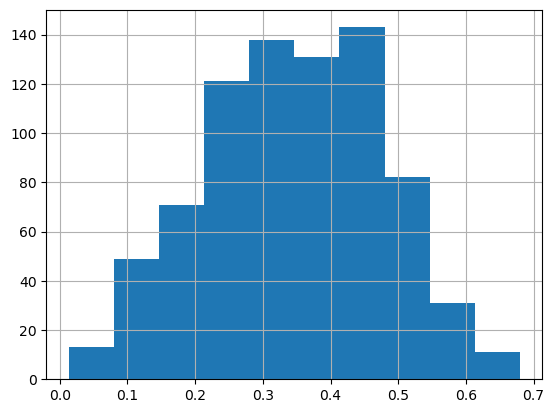

In [27]:
# Creating our histogram
filtered_df['similarity'].hist()

(-21.0, 485.1)

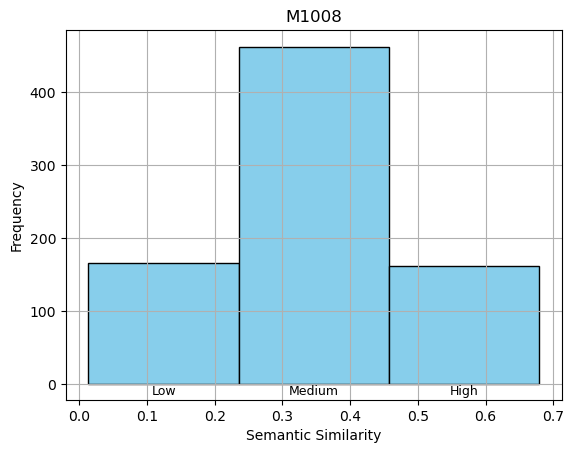

In [48]:
# Now to customize and label
filtered_df['similarity'].hist(bins=3, color= 'skyblue', edgecolor= 'black')
plt.title('M1008')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
counts, bin_edges = np.histogram(filtered_df['similarity'], bins=3)

# Calculate center positions of each bin
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Add category labels under the bars
for center, label in zip(bin_centers, ['Low', 'Medium', 'High']):
    plt.text(center, -0.5, label, ha='center', va='top', fontsize=9)

# Make room below the plot for the labels
plt.ylim(bottom=-21)

### Creating Diagrams to Display Recall Accuracy vs. Semantic Similarity

In [49]:
filtered_df = filtered_df.copy()

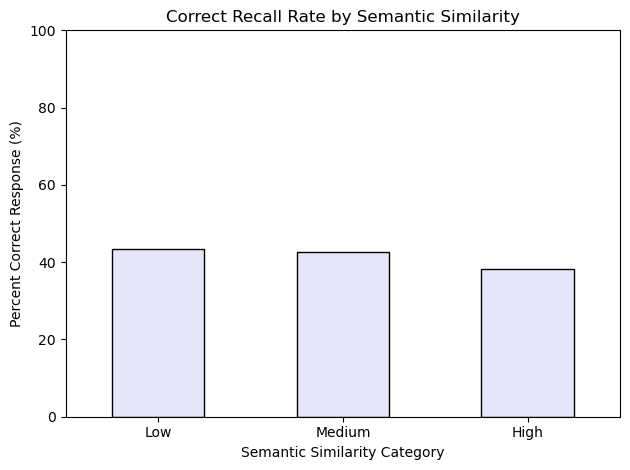

In [50]:
# Sort the dataframe by similarity
sorted_df = filtered_df.sort_values(by='similarity')

# Split into 3 equal-sized bins, based on number of items per bin, not range size
sorted_df['sim_bin'] = pd.qcut(sorted_df['similarity'], q=3, labels=['Low', 'Medium', 'High'])

# Making sure the total includes missing responses (NaN) too
def custom_percent(series):
    total = len(series)                    # Includes NaNs
    correct = (series == 'correct').sum() # Only count actual 'correct'
    return (correct / total) * 100

# Calculate percent of "correct" responses 
grouped = sorted_df.groupby('sim_bin', observed=True)
percent_correct = grouped['results'].apply(custom_percent)

# Plot the bar graph
percent_correct.plot(kind='bar', color='lavender', edgecolor='black')

# Formatting and labeling the graph
plt.ylabel('Percent Correct Response (%)')
plt.xlabel('Semantic Similarity Category')
plt.title('Correct Recall Rate by Semantic Similarity')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()                               

#### Checking that the data was broken up equally into terciles

In [51]:
sorted_df[sorted_df['sim_bin'] == 'Low']

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,sim_bin
219,M1006,1,1,0,False,True,"[PEA, HILL]",[PEA],[HILL],"[[1600.0453514739231, 118, HILL]]",correct,0.013453,Low
451,M1011,0,6,1,True,False,"[WOOD, MAT]",[WOOD],[MAT],"[[1142.4263038548752, 152, MAT]]",correct,0.044113,Low
628,M1012,0,5,1,False,True,"[EEL, MULE]",[EEL],[MULE],"[[1909.546485260771, 163, MULE]]",correct,0.048947,Low
20,M1005,0,6,2,False,False,"[CART, WASP]",[CART],[WASP],"[[8015.600907029479, -1, <>]]",NaN,0.056874,Low
130,M1005,3,7,1,True,False,"[ELF, JAR]",[ELF],[JAR],"[[1337.6417233560092, 80, ELF]]",read,0.064417,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,M1005,0,10,0,False,True,"[PAIL, MOLE]",[PAIL],[MOLE],"[[8009.251700680272, -1, <>]]",NaN,0.284543,Low
24,M1005,0,8,0,False,True,"[SOAP, SWORD]",[SOAP],[SWORD],"[[8016.575963718822, -1, <>]]",NaN,0.286579,Low
455,M1011,0,7,2,False,True,"[PIPE, SLEEVE]",[PIPE],[SLEEVE],"[[831.8820861678005, 226, SLEEVE]]",correct,0.287276,Low
453,M1011,0,7,0,False,True,"[EGG, KITE]",[EGG],[KITE],"[[1247.6643990929706, 136, KITE]]",correct,0.287407,Low


In [52]:
sorted_df[sorted_df['sim_bin'] == 'Medium']

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,sim_bin
364,M1008,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],"[[2341.9954648526077, 112, GROUND]]",intrusion,0.288528,Medium
475,M1011,1,2,1,False,False,"[LUNCH, RUG]",[LUNCH],[RUG],"[[6032.539682539683, -1, NICE]]",intrusion,0.288864,Medium
636,M1012,0,8,0,False,False,"[POOL, SKATE]",[POOL],[SKATE],"[[1219.1836734693877, 222, SKATE]]",correct,0.289128,Medium
283,M1006,2,10,1,False,True,"[VASE, SUN]",[VASE],[SUN],"[[1054.0136054421769, 265, SUN]]",correct,0.290378,Medium
278,M1006,2,8,2,True,False,"[DIME, FRUIT]",[DIME],[FRUIT],"[[1097.0068027210884, 98, FRUIT]]",correct,0.291135,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,M1011,2,9,2,True,False,"[SMILE, BOARD]",[SMILE],[BOARD],"[[2811.9274376417234, 22, BOARD]]",correct,0.410831,Medium
292,M1007,0,1,1,False,False,"[POLE, BLOOM]",[POLE],[BLOOM],"[[2526.938775510204, 94, FOX], [3526.938775510204, -1, <>], [4222.97052154195, -1, <>]]",intrusion,0.411063,Medium
252,M1006,2,0,0,True,False,"[GATE, STRAW]",[GATE],[STRAW],"[[1467.4149659863947, 261, STRAW]]",correct,0.413387,Medium
791,M1013,1,2,2,True,False,"[WORLD, WEED]",[WORLD],[WEED],"[[1717.7551020408164, -1, JUICE]]",intrusion,0.413440,Medium


In [53]:
sorted_df[sorted_df['sim_bin'] == 'High']

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,sim_bin
143,M1005,3,11,2,True,False,"[BAG, BEEF]",[BAG],[BEEF],"[[596.3492063492064, 16, BEEF], [896.9160997732426, 6, BAG]]",correct,0.414887,High
693,M1012,2,3,0,False,False,"[STORE, MASK]",[STORE],[MASK],"[[2301.156462585034, -1, <>]]",NaN,0.414947,High
566,M1011,3,8,2,False,True,"[SNAIL, OWL]",[SNAIL],[OWL],"[[2246.5079365079364, 228, SLIME]]",intrusion,0.414983,High
411,M1008,1,5,0,True,False,"[SHELL, MOOSE]",[SHELL],[MOOSE],"[[1276.077097505669, 157, MOOSE]]",correct,0.415486,High
90,M1005,2,6,0,True,False,"[SKUNK, PORK]",[SKUNK],[PORK],"[[2180.8616780045354, 224, SKUNK], [3309.0249433106574, -1, WORK]]",read,0.415492,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,M1005,0,2,0,True,False,"[BLUSH, CHEEK]",[BLUSH],[CHEEK],"[[8016.326530612245, -1, <>]]",NaN,0.640788,High
489,M1011,1,7,0,True,False,"[PERCH, CHEEK]",[PERCH],[CHEEK],"[[1504.0136054421769, 47, CHEEK]]",correct,0.648538,High
86,M1005,2,4,2,False,True,"[STOOL, BLUSH]",[STOOL],[BLUSH],"[[1023.1292517006802, 258, STOOL]]",read,0.660252,High
215,M1006,0,11,2,False,False,"[SNAKE, TOOTH]",[SNAKE],[TOOTH],"[[2082.2448979591836, 282, TOOTH]]",correct,0.678434,High


### Graphing the Results Accross Stimulus Conditions

In [54]:
correct_df = filtered_df[filtered_df['results'] == 'correct']
intrusion_df = filtered_df[filtered_df['results'] == 'intrusion']

In [55]:
# Adding a coulumn for stim conditions using the booleanvalues in stimEnc and stimCR
conditions = [
    (sorted_df['stimEnc'] == False) & (sorted_df['stimCR'] == False),
    (sorted_df['stimEnc'] == True) & (sorted_df['stimCR'] == False),
    (sorted_df['stimEnc'] == False) & (sorted_df['stimCR'] == True)
]

choices = ['noStim', 'stimEnc', 'stimCR']

sorted_df['stim_condition'] = np.select(conditions, choices, default='unknown')
sorted_df

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,sim_bin,stim_condition
219,M1006,1,1,0,False,True,"[PEA, HILL]",[PEA],[HILL],"[[1600.0453514739231, 118, HILL]]",correct,0.013453,Low,stimCR
451,M1011,0,6,1,True,False,"[WOOD, MAT]",[WOOD],[MAT],"[[1142.4263038548752, 152, MAT]]",correct,0.044113,Low,stimEnc
628,M1012,0,5,1,False,True,"[EEL, MULE]",[EEL],[MULE],"[[1909.546485260771, 163, MULE]]",correct,0.048947,Low,stimCR
20,M1005,0,6,2,False,False,"[CART, WASP]",[CART],[WASP],"[[8015.600907029479, -1, <>]]",NaN,0.056874,Low,noStim
130,M1005,3,7,1,True,False,"[ELF, JAR]",[ELF],[JAR],"[[1337.6417233560092, 80, ELF]]",read,0.064417,Low,stimEnc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,M1005,0,2,0,True,False,"[BLUSH, CHEEK]",[BLUSH],[CHEEK],"[[8016.326530612245, -1, <>]]",NaN,0.640788,High,stimEnc
489,M1011,1,7,0,True,False,"[PERCH, CHEEK]",[PERCH],[CHEEK],"[[1504.0136054421769, 47, CHEEK]]",correct,0.648538,High,stimEnc
86,M1005,2,4,2,False,True,"[STOOL, BLUSH]",[STOOL],[BLUSH],"[[1023.1292517006802, 258, STOOL]]",read,0.660252,High,stimCR
215,M1006,0,11,2,False,False,"[SNAKE, TOOTH]",[SNAKE],[TOOTH],"[[2082.2448979591836, 282, TOOTH]]",correct,0.678434,High,noStim


In [ ]:
# Count how many are correct per group
# grouped = filtered_df.groupby(['sim_bin', 'stim_condition'])['correct'].agg(['mean', 'count'])

# Reshape into a DataFrame for plotting
# This puts stim_conditions as columns, and similarity_bin as index
# plot_data = grouped['mean'].unstack(fill_value=0)

# Sort x-axis bins in logical order
# plot_data = plot_data.reindex(['low', 'med', 'high'])

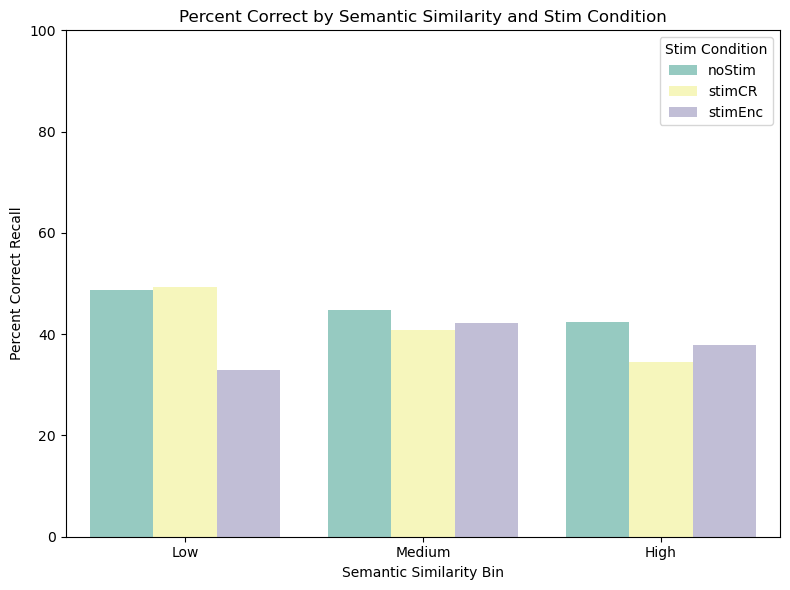

In [56]:

# Filter only correct trials
correct_df = sorted_df[sorted_df['results'] == 'correct']

# Count corrects per (sim_bin, stim_condition)
correct_counts = correct_df.groupby(['sim_bin', 'stim_condition'], observed=True).size().reset_index(name='correct_count')

# Count total trials per (sim_bin, stim_condition)
total_counts = sorted_df.groupby(['sim_bin', 'stim_condition'], observed=True).size().reset_index(name='total_count')

# Merge and calculate percent correct
merged = pd.merge(total_counts, correct_counts, on=['sim_bin', 'stim_condition'], how='left')
merged['correct_count'] = merged['correct_count'].fillna(0)  # fill missing with 0
merged['percent_correct'] = (merged['correct_count'] / merged['total_count']) * 100

# Plot grouped bar chart 
plt.figure(figsize=(8, 6))
sns.barplot(data=merged, x='sim_bin', y='percent_correct', hue='stim_condition', palette='Set3')

plt.xlabel('Semantic Similarity Bin')
plt.ylabel('Percent Correct Recall')
plt.title('Percent Correct by Semantic Similarity and Stim Condition')
plt.ylim(0, 100)
plt.legend(title='Stim Condition')
plt.tight_layout()
plt.show()

## Semantic Similarity Analyses of Intruded Words

In [57]:
# Pull intruded words from the data column
def extract_intruded_word(cell):
    matches = re.findall(r'\[.*?,.*?,\s*([^\[\],<> ]+)\]', str(cell))
    return matches[-1] if matches else None

# Apply the function to the intrusion dataframe
intrusion_df = intrusion_df.copy()
intrusion_df['intruded_word'] = intrusion_df['data'].apply(extract_intruded_word)

In [58]:
intrusion_df

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,intruded_word
45,M1005,1,3,0,True,False,"[SHIELD, BUG]",[SHIELD],[BUG],"[[1105.1927437641725, 211, SEAL]]",intrusion,0.295014,'SEAL'
46,M1005,1,3,1,True,False,"[CAVE, TOOTH]",[CAVE],[TOOTH],"[[581.4965986394558, 271, TEETH]]",intrusion,0.384268,'TEETH'
52,M1005,1,5,1,False,True,"[CAPE, SKI]",[CAPE],[SKI],"[[615.0340136054422, 271, TEETH]]",intrusion,0.178398,'TEETH'
53,M1005,1,5,2,False,True,"[BREAD, STEAM]",[BREAD],[STEAM],"[[1859.8185941043084, 18, BIRD]]",intrusion,0.435945,'BIRD'
54,M1005,1,6,0,False,True,"[ROD, BEAK]",[ROD],[BEAK],"[[1625.5555555555557, -1, RIDE]]",intrusion,0.297218,'RIDE'
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,M1013,1,0,1,False,False,"[RAIL, POLE]",[RAIL],[POLE],"[[2095.1020408163267, 47, CHEEK]]",intrusion,0.342798,'CHEEK'
790,M1013,1,2,1,True,False,"[STEM, OWL]",[STEM],[OWL],"[[1827.8684807256236, 262, STREET]]",intrusion,0.192187,'STREET'
791,M1013,1,2,2,True,False,"[WORLD, WEED]",[WORLD],[WEED],"[[1717.7551020408164, -1, JUICE]]",intrusion,0.413440,'JUICE'
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion,0.635417,'SNAIL'


In [59]:
# Making sure everything is a clean string that word2vec can process
def clean_word(word):
    # If it's a list, extract the first element
    if isinstance(word, list) and len(word) > 0:
        word = word[0]
    
    # If it's not a string now, something is wrong
    if not isinstance(word, str):
        return None
    
    # Remove brackets, quotes, whitespace, and make sure everything is uppercase
    cleaned = re.sub(r"[\[\]'\" ]", "", word)
    return cleaned.upper() if cleaned else None

In [60]:
# Get similarity for cue vs. intrusion word pair
def get_similarity(row):
    word1 = clean_word(row['cue'])
    word2 = clean_word(row['intruded_word'])
    
    if not word1 or not word2:
        return None
    if word1 not in word2vec.key_to_index or word2 not in word2vec.key_to_index:
        return None
    return word2vec.similarity(word1, word2)

intrusion_df['cue_intrusion_sim'] = intrusion_df.apply(get_similarity, axis=1)
intrusion_df

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,intruded_word,cue_intrusion_sim
45,M1005,1,3,0,True,False,"[SHIELD, BUG]",[SHIELD],[BUG],"[[1105.1927437641725, 211, SEAL]]",intrusion,0.295014,'SEAL',0.285803
46,M1005,1,3,1,True,False,"[CAVE, TOOTH]",[CAVE],[TOOTH],"[[581.4965986394558, 271, TEETH]]",intrusion,0.384268,'TEETH',0.389057
52,M1005,1,5,1,False,True,"[CAPE, SKI]",[CAPE],[SKI],"[[615.0340136054422, 271, TEETH]]",intrusion,0.178398,'TEETH',0.364310
53,M1005,1,5,2,False,True,"[BREAD, STEAM]",[BREAD],[STEAM],"[[1859.8185941043084, 18, BIRD]]",intrusion,0.435945,'BIRD',0.360289
54,M1005,1,6,0,False,True,"[ROD, BEAK]",[ROD],[BEAK],"[[1625.5555555555557, -1, RIDE]]",intrusion,0.297218,'RIDE',0.293525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,M1013,1,0,1,False,False,"[RAIL, POLE]",[RAIL],[POLE],"[[2095.1020408163267, 47, CHEEK]]",intrusion,0.342798,'CHEEK',0.392213
790,M1013,1,2,1,True,False,"[STEM, OWL]",[STEM],[OWL],"[[1827.8684807256236, 262, STREET]]",intrusion,0.192187,'STREET',0.096302
791,M1013,1,2,2,True,False,"[WORLD, WEED]",[WORLD],[WEED],"[[1717.7551020408164, -1, JUICE]]",intrusion,0.413440,'JUICE',0.394660
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion,0.635417,'SNAIL',0.474452


In [61]:
# get similarity for nonCue vs. intrusion word pair
def get_similarity2(row):
    word1 = clean_word(row['nonCue'])
    word2 = clean_word(row['intruded_word'])
    
    if not word1 or not word2:
        return None
    if word1 not in word2vec.key_to_index or word2 not in word2vec.key_to_index:
        return None
    return word2vec.similarity(word1, word2)

intrusion_df['nonCue_intrusion_sim'] = intrusion_df.apply(get_similarity2, axis=1)
intrusion_df

,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim
45,M1005,1,3,0,True,False,"[SHIELD, BUG]",[SHIELD],[BUG],"[[1105.1927437641725, 211, SEAL]]",intrusion,0.295014,'SEAL',0.285803,0.246357
46,M1005,1,3,1,True,False,"[CAVE, TOOTH]",[CAVE],[TOOTH],"[[581.4965986394558, 271, TEETH]]",intrusion,0.384268,'TEETH',0.389057,0.743568
52,M1005,1,5,1,False,True,"[CAPE, SKI]",[CAPE],[SKI],"[[615.0340136054422, 271, TEETH]]",intrusion,0.178398,'TEETH',0.364310,0.331470
53,M1005,1,5,2,False,True,"[BREAD, STEAM]",[BREAD],[STEAM],"[[1859.8185941043084, 18, BIRD]]",intrusion,0.435945,'BIRD',0.360289,0.363528
54,M1005,1,6,0,False,True,"[ROD, BEAK]",[ROD],[BEAK],"[[1625.5555555555557, -1, RIDE]]",intrusion,0.297218,'RIDE',0.293525,0.220587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,M1013,1,0,1,False,False,"[RAIL, POLE]",[RAIL],[POLE],"[[2095.1020408163267, 47, CHEEK]]",intrusion,0.342798,'CHEEK',0.392213,0.553046
790,M1013,1,2,1,True,False,"[STEM, OWL]",[STEM],[OWL],"[[1827.8684807256236, 262, STREET]]",intrusion,0.192187,'STREET',0.096302,0.214304
791,M1013,1,2,2,True,False,"[WORLD, WEED]",[WORLD],[WEED],"[[1717.7551020408164, -1, JUICE]]",intrusion,0.413440,'JUICE',0.394660,0.487512
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion,0.635417,'SNAIL',0.474452,0.411069


#### Making our graphs

In [62]:
# First add stim conditions to this new dataframe
conditions = [
    (intrusion_df['stimEnc'] == False) & (intrusion_df['stimCR'] == False),
    (intrusion_df['stimEnc'] == True) & (intrusion_df['stimCR'] == False),
    (intrusion_df['stimEnc'] == False) & (intrusion_df['stimCR'] == True)
]

choices = ['noStim', 'stimEnc', 'stimCR']

intrusion_df['stim_condition'] = np.select(conditions, choices, default='unknown')
intrusion_df


,subject,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,data,results,similarity,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim,stim_condition
45,M1005,1,3,0,True,False,"[SHIELD, BUG]",[SHIELD],[BUG],"[[1105.1927437641725, 211, SEAL]]",intrusion,0.295014,'SEAL',0.285803,0.246357,stimEnc
46,M1005,1,3,1,True,False,"[CAVE, TOOTH]",[CAVE],[TOOTH],"[[581.4965986394558, 271, TEETH]]",intrusion,0.384268,'TEETH',0.389057,0.743568,stimEnc
52,M1005,1,5,1,False,True,"[CAPE, SKI]",[CAPE],[SKI],"[[615.0340136054422, 271, TEETH]]",intrusion,0.178398,'TEETH',0.364310,0.331470,stimCR
53,M1005,1,5,2,False,True,"[BREAD, STEAM]",[BREAD],[STEAM],"[[1859.8185941043084, 18, BIRD]]",intrusion,0.435945,'BIRD',0.360289,0.363528,stimCR
54,M1005,1,6,0,False,True,"[ROD, BEAK]",[ROD],[BEAK],"[[1625.5555555555557, -1, RIDE]]",intrusion,0.297218,'RIDE',0.293525,0.220587,stimCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,M1013,1,0,1,False,False,"[RAIL, POLE]",[RAIL],[POLE],"[[2095.1020408163267, 47, CHEEK]]",intrusion,0.342798,'CHEEK',0.392213,0.553046,noStim
790,M1013,1,2,1,True,False,"[STEM, OWL]",[STEM],[OWL],"[[1827.8684807256236, 262, STREET]]",intrusion,0.192187,'STREET',0.096302,0.214304,stimEnc
791,M1013,1,2,2,True,False,"[WORLD, WEED]",[WORLD],[WEED],"[[1717.7551020408164, -1, JUICE]]",intrusion,0.413440,'JUICE',0.394660,0.487512,stimEnc
799,M1013,1,5,1,True,False,"[BROOK, MARSH]",[BROOK],[MARSH],"[[2974.852607709751, 236, SNAIL]]",intrusion,0.635417,'SNAIL',0.474452,0.411069,stimEnc


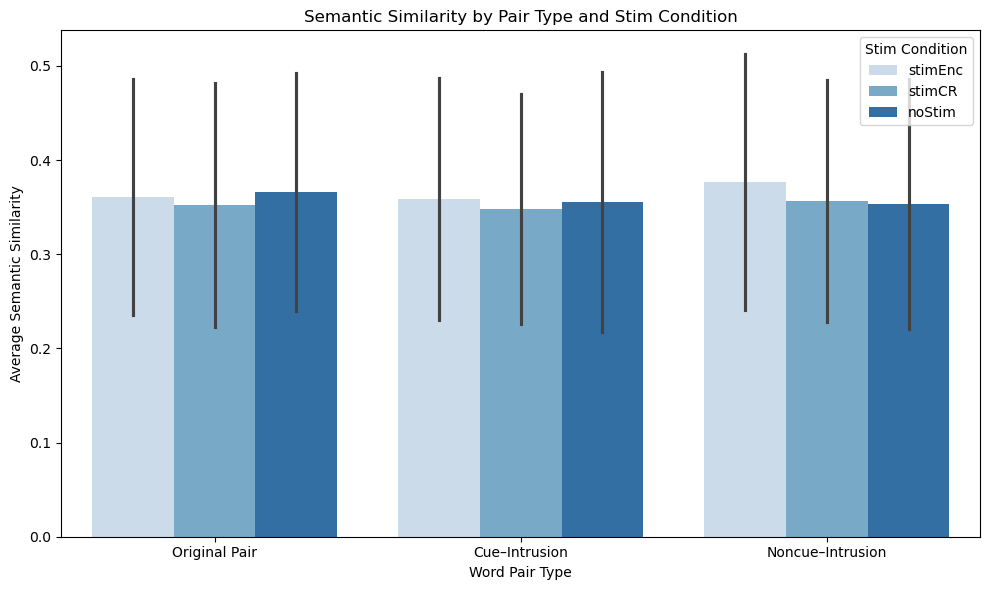

In [65]:
# Step 1: Melt the dataframe — reshape it to long format
melted = pd.melt(
    intrusion_df,
    id_vars=['stim_condition'],
    value_vars=['similarity', 'cue_intrusion_sim', 'nonCue_intrusion_sim'],
    var_name='pair_type',
    value_name='similarity_value'
)

# Step 2: Clean up the labels for pair_type for clarity (optional)
label_map = {
    'similarity': 'Original Pair',
    'cue_intrusion_sim': 'Cue–Intrusion',
    'nonCue_intrusion_sim': 'Noncue–Intrusion'
}
melted['pair_type'] = melted['pair_type'].map(label_map)

# Step 3: Drop rows where similarity is NaN (if any)
melted = melted.dropna(subset=['similarity_value'])

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted,
    x='pair_type',
    y='similarity_value',
    hue='stim_condition',
    errorbar='sd',
    palette=sns.color_palette("Blues", 3)
)
plt.title("Semantic Similarity by Pair Type and Stim Condition")
plt.xlabel("Word Pair Type")
plt.ylabel("Average Semantic Similarity")
plt.legend(title="Stim Condition")
plt.tight_layout()
plt.show()

In [24]:
# Make a copy (already ran this)
# !cp Semantic_Similarity_allSubjects.ipynb Copy_For_Andrew.ipynb

### Trying to change analyses to show variation across subjects

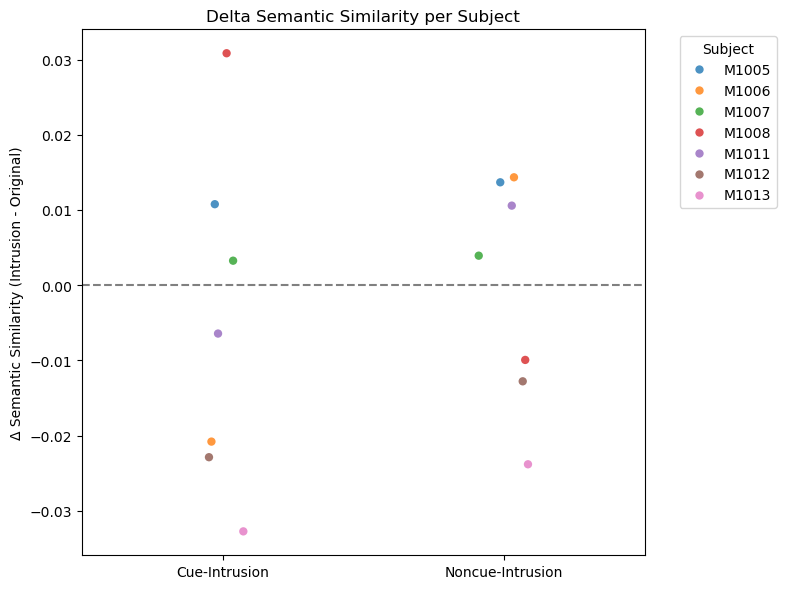

In [91]:
# Step 1: Group by subject and calculate means
grouped = intrusion_df.groupby('subject').agg({
    'similarity': 'mean',
    'cue_intrusion_sim': 'mean',
    'nonCue_intrusion_sim': 'mean'
}).reset_index()

# Step 2: Compute delta values
grouped['delta_cue'] = grouped['cue_intrusion_sim'] - grouped['similarity']
grouped['delta_noncue'] = grouped['nonCue_intrusion_sim'] - grouped['similarity']

# Step 3: Reshape for plotting
plot_df = pd.melt(grouped, 
                  id_vars='subject', 
                  value_vars=['delta_cue', 'delta_noncue'], 
                  var_name='IntrusionType', 
                  value_name='DeltaSimilarity')

# Optional: cleaner x-labels
plot_df['IntrusionType'] = plot_df['IntrusionType'].map({
    'delta_cue': 'Cue-Intrusion',
    'delta_noncue': 'Noncue-Intrusion'
})

# Step 4: Plot
plt.figure(figsize=(8, 6))
sns.stripplot(data=plot_df, 
              x='IntrusionType', 
              y='DeltaSimilarity',
              hue='subject',
              jitter=True, 
              size=6, 
              alpha=0.8, 
              palette='tab10')

# Add horizontal line at y=0
plt.axhline(0, linestyle='--', color='gray')

plt.title('Delta Semantic Similarity per Subject')
plt.ylabel('Δ Semantic Similarity (Intrusion - Original)')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Subject')
plt.tight_layout()
plt.show()

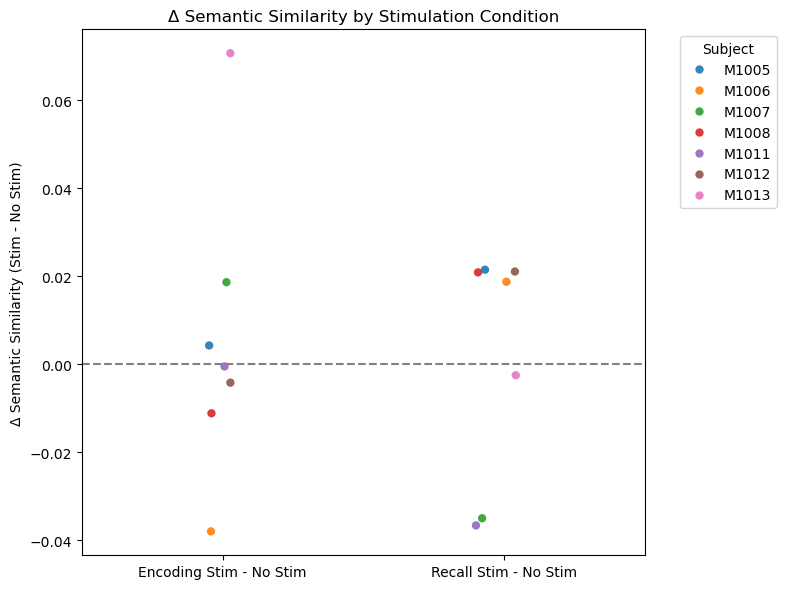

In [101]:
# Step 1: Compute Encoding Delta per subject
enc_group = intrusion_df.groupby(['subject', 'stimEnc'])['similarity'].mean().unstack()
enc_group['delta_encoding'] = enc_group[True] - enc_group[False]

# Step 2: Compute Cued Recall Delta per subject
cr_group = intrusion_df.groupby(['subject', 'stimCR'])['similarity'].mean().unstack()
cr_group['delta_recall'] = cr_group[True] - cr_group[False]

# Step 3: Combine both deltas into a new DataFrame
delta_df = pd.DataFrame({
    'subject': enc_group.index,
    'Delta Encoding': enc_group['delta_encoding'],
    'Delta Recall': cr_group['delta_recall']
}).reset_index(drop=True)

# Step 4: Reshape for plotting
plot_df = pd.melt(delta_df, 
                  id_vars='subject', 
                  value_vars=['Delta Encoding', 'Delta Recall'], 
                  var_name='StimCondition', 
                  value_name='DeltaSimilarity')

# Optional: clean labels
plot_df['StimCondition'] = plot_df['StimCondition'].map({
    'Delta Encoding': 'Encoding Stim - No Stim',
    'Delta Recall': 'Recall Stim - No Stim'
})

# Step 5: Plot
plt.figure(figsize=(8, 6))
sns.stripplot(
    data=plot_df,
    x='StimCondition',
    y='DeltaSimilarity',
    hue='subject',
    jitter=True,
    size=6,
    alpha=0.9,
    palette='tab10'
)

plt.axhline(0, linestyle='--', color='gray')
plt.title('Δ Semantic Similarity by Stimulation Condition')
plt.ylabel('Δ Semantic Similarity (Stim - No Stim)')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Subject')
plt.tight_layout()
plt.show()

In [94]:
print(intrusion_df.columns.tolist())

['subject', 'session', 'trial', 'item', 'stimEnc', 'stimCR', 'pairedWords', 'cue', 'nonCue', 'data', 'results', 'similarity', 'intruded_word', 'cue_intrusion_sim', 'nonCue_intrusion_sim', 'stim_condition']
